In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from read_roi import read_roi_zip
import matplotlib.patches as patches
import hdbscan
from helper_functions import subset, calculate_ari_ami_matrix, spex_distance, find_nuclei_centroids
import itertools
from hdbscan.validity import validity_index
from scipy.spatial import Voronoi, voronoi_plot_2d
from tabulate import tabulate


# Hyperparameter tuning

## Bandwidth of kernel

In [2]:
data_directory = r"C:\Users\geertoosterbroek\Documents\Thesis\Data\507_s7\input"
labels_bandwidths = pd.read_pickle(os.path.join(data_directory, "labels_different_bandwidth.pkl"))
labels_bandwidths = pd.DataFrame.from_dict(labels_bandwidths)

In [3]:
ari_scores = calculate_ari_ami_matrix(labels_bandwidths, 'ARI')
ami_scores = calculate_ari_ami_matrix(labels_bandwidths, 'AMI')

In [11]:
# print(tabulate(np.where(ari_scores==0, '', ari_scores.astype('U')), tablefmt="latex", floatfmt=".2f"))
print(tabulate(ari_scores, tablefmt="latex", floatfmt=".2f"))
print(tabulate(ami_scores, tablefmt="latex", floatfmt=".2f"))

\begin{tabular}{rrrrrrr}
\hline
 1.00 & 0.75 & 0.69 & 0.70 & 0.71 & 0.70 & 0.72 \\
 0.00 & 1.00 & 0.86 & 0.86 & 0.86 & 0.86 & 0.85 \\
 0.00 & 0.00 & 1.00 & 0.97 & 0.96 & 0.95 & 0.93 \\
 0.00 & 0.00 & 0.00 & 1.00 & 0.97 & 0.95 & 0.94 \\
 0.00 & 0.00 & 0.00 & 0.00 & 1.00 & 0.97 & 0.95 \\
 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 1.00 & 0.96 \\
 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 1.00 \\
\hline
\end{tabular}
\begin{tabular}{rrrrrrr}
\hline
 1.00 & 0.79 & 0.75 & 0.75 & 0.75 & 0.75 & 0.76 \\
 0.00 & 1.00 & 0.90 & 0.89 & 0.89 & 0.89 & 0.88 \\
 0.00 & 0.00 & 1.00 & 0.97 & 0.96 & 0.95 & 0.93 \\
 0.00 & 0.00 & 0.00 & 1.00 & 0.97 & 0.95 & 0.95 \\
 0.00 & 0.00 & 0.00 & 0.00 & 1.00 & 0.96 & 0.95 \\
 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 1.00 & 0.97 \\
 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 1.00 \\
\hline
\end{tabular}


In [12]:
spex_data = pd.read_pickle(os.path.join(data_directory, "exp_vec_full.pkl"))
spex_data = subset(spex_data)
spex_npy = spex_data.to_numpy()
for col in labels_bandwidths:
    print(f"DBCV of bandwidth {col}: {validity_index(spex_npy, labels=labels_bandwidths[col], metric=spex_distance)}") # fails with single observation clusters

DBCV of bandwidth 0.1: 0.3937437941833162
DBCV of bandwidth 0.5: 0.49142046845545984
DBCV of bandwidth 0.8: 0.5307273807846918
DBCV of bandwidth 1: 0.4664670732148695
DBCV of bandwidth 1.5: 0.5226297658774248
DBCV of bandwidth 5: 0.42994212396008624
DBCV of bandwidth 10: 0.46771829296990686


## HDBSCAN hyperparameter tuning: m_pts

In [14]:
# selection of values for m_pts
m_pts = [1, 2, 5, 10, 20]
labels_mpts = {}

# Calculate labels for different hyperpar values
for m_pt in m_pts:
    clusterer = hdbscan.HDBSCAN(metric=spex_distance, gen_min_span_tree=True, min_samples=m_pt).fit(spex_data)
    labels_mpts[f'mpts: {m_pt}'] = clusterer.labels_
    
labels_mpts_df = pd.DataFrame.from_dict(labels_mpts)
ari_scores = calculate_ari_ami_matrix(labels_mpts_df, metric='ari')
ami_scores = calculate_ari_ami_matrix(labels_mpts_df, metric='ami')


In [15]:
print(tabulate(ari_scores, tablefmt="latex", floatfmt=".2f"))
print(tabulate(ami_scores, tablefmt="latex", floatfmt=".2f"))

\begin{tabular}{rrrrr}
\hline
 1.00 & 0.88 & 0.78 & 0.73 & 0.68 \\
 0.00 & 1.00 & 0.85 & 0.81 & 0.76 \\
 0.00 & 0.00 & 1.00 & 0.82 & 0.77 \\
 0.00 & 0.00 & 0.00 & 1.00 & 0.89 \\
 0.00 & 0.00 & 0.00 & 0.00 & 1.00 \\
\hline
\end{tabular}
\begin{tabular}{rrrrr}
\hline
 1.00 & 0.88 & 0.79 & 0.76 & 0.73 \\
 0.00 & 1.00 & 0.86 & 0.83 & 0.80 \\
 0.00 & 0.00 & 1.00 & 0.85 & 0.81 \\
 0.00 & 0.00 & 0.00 & 1.00 & 0.89 \\
 0.00 & 0.00 & 0.00 & 0.00 & 1.00 \\
\hline
\end{tabular}


In [16]:
dbcv_scores = {}
for col in labels_mpts_df:
    dbcv_scores[f'{col}'] = validity_index(spex_npy, labels=labels_mpts_df[col], metric=spex_distance)

In [18]:
dbcv_scores


{'mpts: 1': 0.3737940189645429,
 'mpts: 2': 0.39897528745529964,
 'mpts: 5': 0.6165537795222644,
 'mpts: 10': 0.6362346394114565,
 'mpts: 20': 0.4519422502007689}

# Comparing clustering methods

In [2]:
# Load labels of different methods
output_dir = r"C:\Users\geertoosterbroek\Documents\Thesis\Data\507_s7\output\subset"
baysor_data = pd.read_csv(os.path.join(output_dir, "baysor data.csv"), usecols=['x', 'y', 'cell']).rename(
    columns={"cell":"baysor_labels"}
)
baysor_dapi_data = pd.read_csv(os.path.join(output_dir, "baysor data dapi.csv"), usecols=['x', 'y', 'cell']).rename(
    columns={"cell":"baysor_plus_labels"}
)
baysor_data.loc[baysor_data['baysor_labels'] ==0, 'baysor_labels' ] = -1
baysor_dapi_data.loc[baysor_dapi_data['baysor_plus_labels'] ==0 , 'baysor_plus_labels'] = -1
baysor_data = subset(baysor_data)
baysor_dapi_data = subset(baysor_dapi_data)
exp_nuc_data = pd.read_csv(os.path.join(output_dir, "exp_nuc_labelled_data.csv"), index_col=0)
nuc_map_data = pd.read_csv(os.path.join(output_dir, "nucmap_labelled_data.csv"), index_col=0)                         
sedec_data = pd.read_csv(os.path.join(output_dir, "SEDEC_labelled_data.csv"), index_col=0)                           

# Combine labels and coordinates into single DF
all_clusters = pd.concat([exp_nuc_data, baysor_data['baysor_labels'], baysor_dapi_data['baysor_plus_labels'],
                         nuc_map_data['nc_labels'], sedec_data[['sedec_labels', 'sedec_plus_labels']]], 
                         axis='columns')

In [27]:
print(all_clusters.head())
print(all_clusters.shape)
# all_clusters['sedec_plus_labels'].value_counts()

                x            y  target  exp_nuc_labels  baysor_labels  \
3922  3465.170213  1000.063830  Cldn18             770            204   
3923  3450.243902  1000.756098  Cldn18             770            204   
3925  3456.887931  1003.034483  Cldn18             770            204   
3927  3132.928571  1007.357143  Cldn18             757             -1   
3928  3453.396825  1013.222222  Cldn18             770            204   

      baysor_plus_labels  nc_labels  sedec_labels  sedec_plus_labels  
3922                 217        775             0                  1  
3923                 217        775             0                  1  
3925                 217        775             0                  1  
3927                  -1         -1            -1                 -1  
3928                 217        775             0                  1  
(1468, 9)


In [72]:
# Summary stats different clusters
all_clusters.iloc[:,3:].apply(lambda x: print(f"""Number of clusters {x.name}: {x.nunique()} 
                                                Noise percentage: {(sum(x==-1)/len(x)):.2f},
                                                Smallest cluster size: {x.value_counts().min()}"""))

Number of clusters exp_nuc_labels: 44 
                                                Noise percentage: 0.19,
                                                Smallest cluster size: 1
Number of clusters baysor_labels: 16 
                                                Noise percentage: 0.20,
                                                Smallest cluster size: 5
Number of clusters baysor_plus_labels: 16 
                                                Noise percentage: 0.18,
                                                Smallest cluster size: 3
Number of clusters nc_labels: 41 
                                                Noise percentage: 0.02,
                                                Smallest cluster size: 5
Number of clusters sedec_labels: 13 
                                                Noise percentage: 0.16,
                                                Smallest cluster size: 9
Number of clusters sedec_plus_labels: 31 
                                          

exp_nuc_labels         None
baysor_labels          None
baysor_plus_labels     None
nc_labels              None
sedec_labels           None
sedec_plus_labels      None
exp_nuc_labels_dbcv    None
dtype: object

In [5]:
# Load additionally required data
input_directory = r"C:\Users\geertoosterbroek\Documents\Thesis\Data\507_s7\input"
cell_rois = read_roi_zip(input_directory + r"\507_s7_all_cell_rois.zip")
nuclei_rois = read_roi_zip(os.path.join(input_directory, "507_sc7_all_nuclei_RoiSet_crop.zip"))

# Visual inspection

In [42]:
def make_visual(combined_clusters, method='sedec', save=True, nuclei_rois = None, cell_rois = None):

    fig_dir = r"C:\Users\geertoosterbroek\Documents\Thesis\Images"

    num_clusters = combined_clusters[f'{method}_labels'].nunique()
    # color = iter(plt.cm.jet(np.linspace(0,1,num_clusters)))
    color = itertools.cycle(plt.cm.jet(np.linspace(0,1,num_clusters)))
    used_markers = itertools.cycle(('s', '^', 'D'))
    fig, ax = plt.subplots(dpi=1000)

    if method == 'baysor_plus':
    # add processed dapi background
        datafile = r"C:\Users\geertoosterbroek\Documents\Thesis\Data\507_s7\Channel images\zoomed_dapi3.jpg"
        img = plt.imread(datafile)
        ax.imshow(img, zorder=0, extent=[3000,3500,1000,1500], cmap='Greens_r')
    
    for n, grp in combined_clusters.groupby(f'{method}_labels'):
        if n == -1:
            ax.scatter(x='x', y='y', color='black', marker= 'o', data=grp, s=1)
        else:
            ax.scatter(x='x', y='y', color=next(color), marker=next(used_markers), data=grp, s=1)
    # ax.collections[-1].colorbar.remove()
    # ax.set_axis_off()
    ax.set_axis_off()
    ax.set_aspect('equal')
    
    if method == 'nc' or method == 'sedec_plus':
        centroids = find_nuclei_centroids(nuclei_rois)
        vor = Voronoi(centroids)
        voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False, line_width=0.5)
        ax.plot(vor.points[:,0], vor.points[:,1], '.',color="purple", marker=".", markersize=5)
    elif method == 'exp_nuc':
        for key in cell_rois.keys():
            xy = np.column_stack((cell_rois[key]['x'], cell_rois[key]['y']))
            poly = patches.Polygon(xy)
            path = poly.get_path()
            patch = patches.PathPatch(path, facecolor='none', lw=0.5, edgecolor= 'black')
            ax.add_patch(patch)
            
    ax.axis((3000,3500,1000,1500))
    ax.invert_yaxis()
    
    if save:
        fig.savefig(os.path.join(fig_dir, f"{method}_subset2.png"),
                    bbox_inches = 'tight', dpi=300)

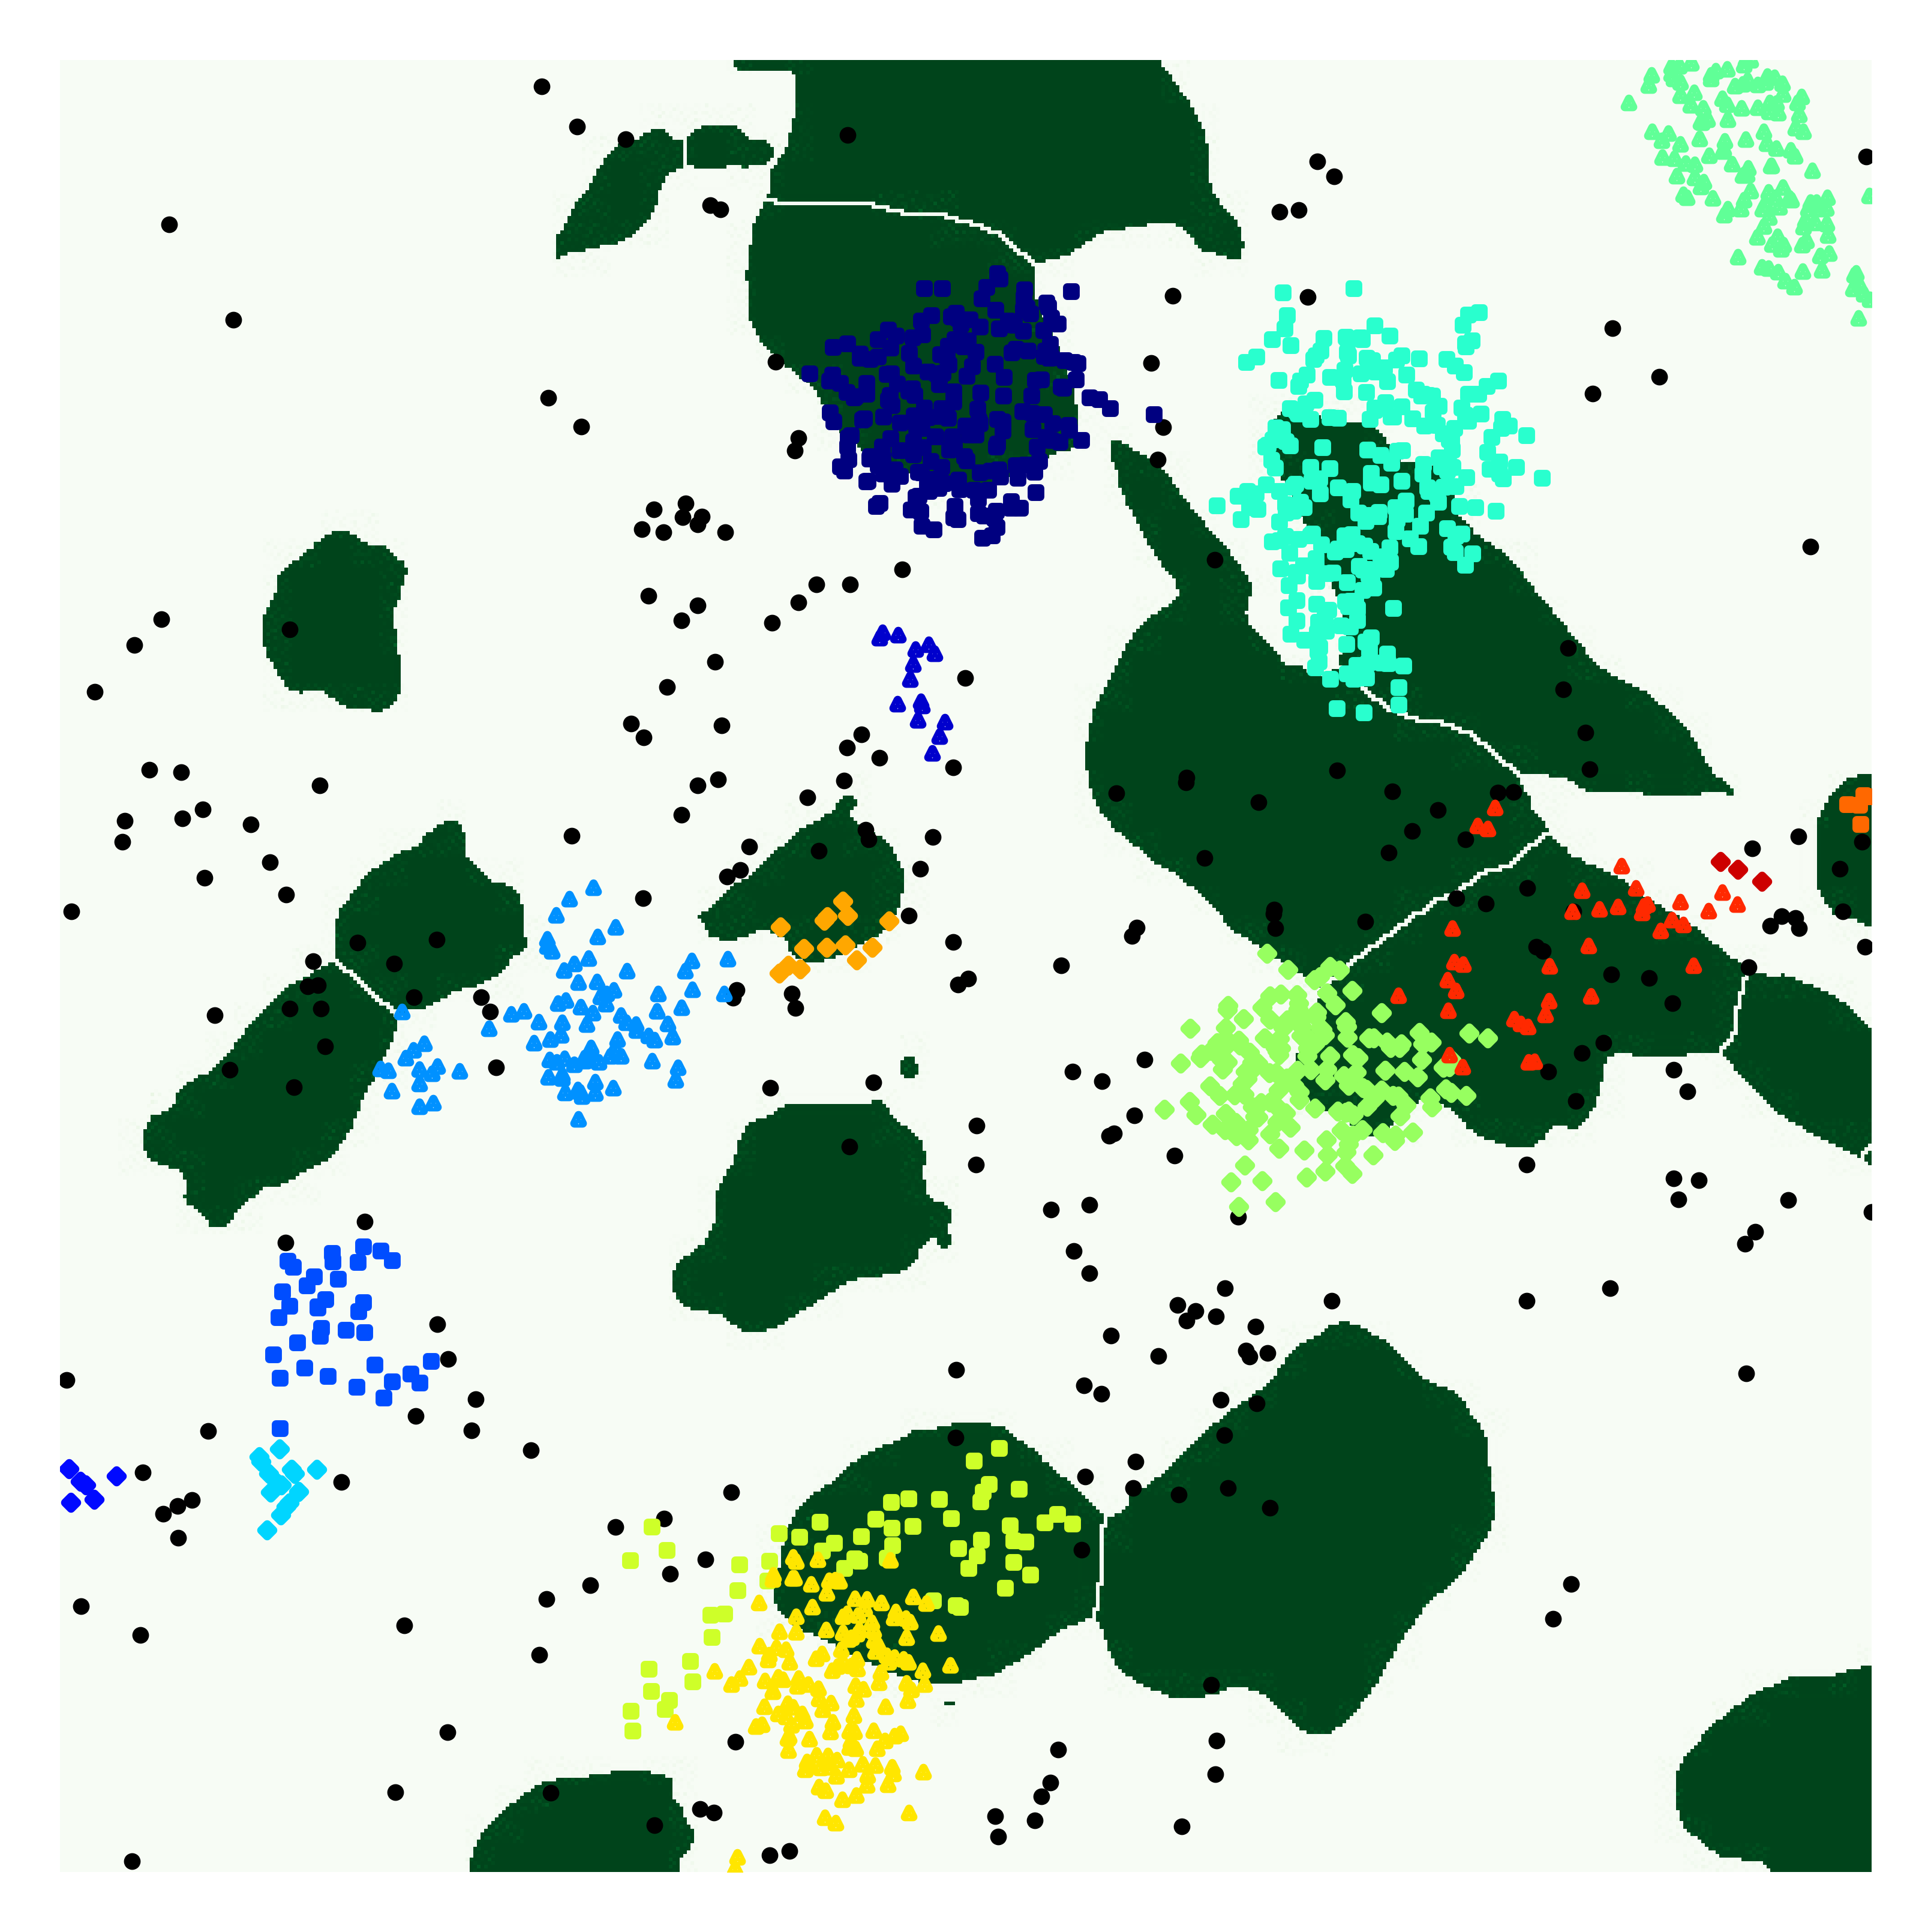

In [43]:
%matplotlib inline
# make_visual(all_clusters, 'sedec')
# make_visual(all_clusters, 'sedec_plus', nuclei_rois=nuclei_rois)
# make_visual(all_clusters, 'baysor')
# make_visual(all_clusters, 'exp_nuc', cell_rois = cell_rois)
# make_visual(all_clusters, 'nc', nuclei_rois=nuclei_rois)
make_visual(all_clusters, 'baysor_plus', nuclei_rois=nuclei_rois)

array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

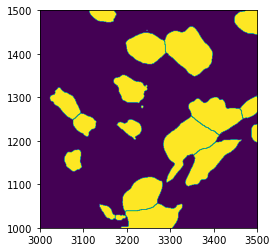

In [88]:
datafile = r"C:\Users\geertoosterbroek\Documents\Thesis\Data\507_s7\Channel images\zoomed_dapi.tif"
img = plt.imread(datafile)
plt.imshow(img, zorder=0, extent=[3000,3500,1000,1500])
img

## Internal validation

In [29]:
all_clusters.head()


,x,y,target,sedec_labels,baysor_labels,exp_nuc_labels,voronoi_labels
3922,3465.170213,1000.063830,Cldn18,0,204,770,775
3923,3450.243902,1000.756098,Cldn18,0,204,770,775
3925,3456.887931,1003.034483,Cldn18,0,204,770,775
3927,3132.928571,1007.357143,Cldn18,-1,-1,757,-1
3928,3453.396825,1013.222222,Cldn18,0,204,770,775


In [30]:
ari_scores = calculate_ari_ami_matrix(all_clusters.iloc[:,3:], metric='ari')
ami_scores = calculate_ari_ami_matrix(all_clusters.iloc[:,3:], metric='ami')
print(tabulate(ari_scores, tablefmt="latex", floatfmt=".2f"))
print(tabulate(ami_scores, tablefmt="latex", floatfmt=".2f"))

\begin{tabular}{rrrr}
\hline
 1.00 & 0.82 & 0.44 & 0.55 \\
 0.00 & 1.00 & 0.46 & 0.55 \\
 0.00 & 0.00 & 1.00 & 0.54 \\
 0.00 & 0.00 & 0.00 & 1.00 \\
\hline
\end{tabular}
\begin{tabular}{rrrr}
\hline
 1.00 & 0.85 & 0.64 & 0.70 \\
 0.00 & 1.00 & 0.65 & 0.69 \\
 0.00 & 0.00 & 1.00 & 0.72 \\
 0.00 & 0.00 & 0.00 & 1.00 \\
\hline
\end{tabular}


In [71]:
unique, counts = np.unique(all_clusters['exp_nuc_labels'], return_counts=True)
sufficient_clusters = unique[counts >= 3]
print(np.asarray((unique, counts)).T)
all_clusters['exp_nuc_labels_dbcv'] = np.asarray([i if i in sufficient_clusters else -1 for i in all_clusters['exp_nuc_labels']])

[[  -1  274]
 [ 757    3]
 [ 770  129]
 [ 788   42]
 [ 793    9]
 [ 800   10]
 [ 801  199]
 [ 807    1]
 [ 812  144]
 [ 828   18]
 [ 841   28]
 [ 846    7]
 [ 856    8]
 [ 858    4]
 [ 862   20]
 [ 866   12]
 [ 867    1]
 [ 877   34]
 [ 883   25]
 [ 885    6]
 [ 894   30]
 [ 895   47]
 [ 897   55]
 [ 913   30]
 [ 914   58]
 [ 917    8]
 [ 919    4]
 [ 934    2]
 [ 935   31]
 [ 939    6]
 [ 942    3]
 [ 954    2]
 [ 959    9]
 [ 961   13]
 [ 976   31]
 [ 998   13]
 [1003   65]
 [1008    4]
 [1009   11]
 [1012   28]
 [1024    3]
 [1045    7]
 [1049   31]
 [1073    3]]


In [78]:
# DBCV
input_directory = r"C:\Users\geertoosterbroek\Documents\Thesis\Data\507_s7\input"
spex_data = pd.read_pickle(os.path.join(input_directory, "exp_vec_full.pkl"))
spex_data = subset(spex_data)
spex_npy = spex_data.to_numpy()
coordinates = all_clusters[['x', 'y']].to_numpy()
all_clusters.iloc[:,4:].apply(lambda x: print(f"""DBCV SPEX {x.name}: {validity_index(spex_npy, labels=x, metric=spex_distance)} 
                                                DBCV Euclidean: {validity_index(coordinates, labels=x, metric='euclidean')} """))

DBCV SPEX baysor_labels: 0.26226621754566626 
                                                DBCV Euclidean: 0.20425505875984343 
DBCV SPEX baysor_plus_labels: 0.2512802516224327 
                                                DBCV Euclidean: 0.1909427403575358 
DBCV SPEX nc_labels: -0.5544799913614032 
                                                DBCV Euclidean: -0.4445863094427178 
DBCV SPEX sedec_labels: 0.6362346394114565 
                                                DBCV Euclidean: 0.31425066559544046 
DBCV SPEX sedec_plus_labels: -0.393421231103736 
                                                DBCV Euclidean: -0.32108682706372405 
DBCV SPEX exp_nuc_labels_dbcv: -0.08943394498262697 
                                                DBCV Euclidean: -0.19093105468691682 


baysor_labels          None
baysor_plus_labels     None
nc_labels              None
sedec_labels           None
sedec_plus_labels      None
exp_nuc_labels_dbcv    None
dtype: object

In [3]:
all_clusters.head()

,x,y,target,exp_nuc_labels,baysor_labels,baysor_plus_labels,nc_labels,sedec_labels,sedec_plus_labels
3922,3465.170213,1000.063830,Cldn18,770,204,217,775,0,1
3923,3450.243902,1000.756098,Cldn18,770,204,217,775,0,1
3925,3456.887931,1003.034483,Cldn18,770,204,217,775,0,1
3927,3132.928571,1007.357143,Cldn18,757,-1,-1,-1,-1,-1
3928,3453.396825,1013.222222,Cldn18,770,204,217,775,0,1


## Internal validation extension

In [5]:
ari_scores = calculate_ari_ami_matrix(all_clusters.iloc[:,[8,5,7,4]], metric='ari')
ami_scores = calculate_ari_ami_matrix(all_clusters.iloc[:,[8,5,7,4]], metric='ami')
print(tabulate(ari_scores, tablefmt="latex", floatfmt=".2f"))
print(tabulate(ami_scores, tablefmt="latex", floatfmt=".2f"))

\begin{tabular}{rrrr}
\hline
 1.00 & 0.68 & 0.75 & 0.68 \\
 0.00 & 1.00 & 0.83 & 0.96 \\
 0.00 & 0.00 & 1.00 & 0.82 \\
 0.00 & 0.00 & 0.00 & 1.00 \\
\hline
\end{tabular}
\begin{tabular}{rrrr}
\hline
 1.00 & 0.77 & 0.86 & 0.77 \\
 0.00 & 1.00 & 0.86 & 0.96 \\
 0.00 & 0.00 & 1.00 & 0.85 \\
 0.00 & 0.00 & 0.00 & 1.00 \\
\hline
\end{tabular}
